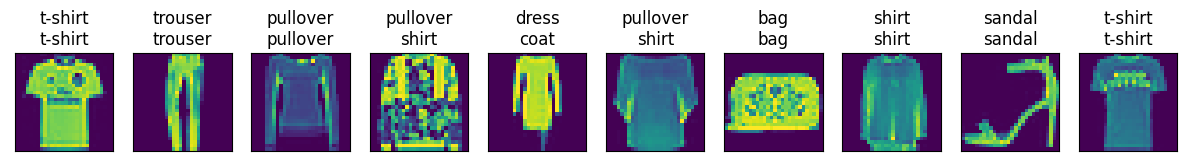

In [1]:
import mxnet as mx
from mxnet import nd,np,gluon,npx,autograd,init
from mxnet.gluon import nn
import sys
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

npx.set_np()

# num_inputs = 784
# num_outputs = 10
batch_size = 256
num_epochs = 10
lr = 0.11#learning rate
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

def get_dataloader_workers():  #@save
    """在非Windows的平台上，使用4个进程来读取数据"""
    return 0 if sys.platform.startswith('win') else 10

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))


#@save
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(cmp.astype(y.dtype).sum())

# W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
# b = np.zeros(num_outputs)
# W.attach_grad()
# b.attach_grad()

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

# def net(X):
#     return softmax(np.dot(X.reshape((-1, W.shape[0])), W) + b)

# def sgd(params, lr, batch_size):  # @save
#     """小批量随机梯度下降"""
#     '''
#     在机器学习中，.sgd 函数通常指的是随机梯度下降（Stochastic Gradient Descent）的缩写，它是一种用于优化模型参数的算法。
#     随机梯度下降是梯度下降算法的一种变体，用于在大规模数据集上训练模型时减少计算成本。
#     '''
#     for param in params:
#         param[:] = param - lr * param.grad / batch_size

    
# def softmax(X):
#     X_exp = np.exp(X)
#     partition = X_exp.sum(1, keepdims=True)
#     return X_exp / partition  # 这里应用了广播机制

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y),  y.size)
    return metric[0] / metric[1]

# def cross_entropy(y_hat, y): # 交叉熵
#     return - np.log(y_hat[range(len(y_hat)), y])

def data_iter(batch_size, features, labels):# 这些样本是随机读取的，没有特定的顺序
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
# evaluate_accuracy(net, test_iter)

# def updater(batch_size):
#     return sgd([W, b], lr, batch_size)

updater = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

def train_epoch(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    metric = Accumulator(3)# 训练损失总和、训练准确度总和、样本数
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        # 计算梯度并更新参数
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.shape[0])# 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda:  set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    
loss = gluon.loss.SoftmaxCrossEntropyLoss()

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def train(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
#     animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.2, 0.9],
#                         legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
#         animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
#     assert train_loss < 0.5, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc

def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


train_iter, test_iter =  load_data_fashion_mnist(batch_size) 
train(net, train_iter, test_iter, loss, num_epochs, updater)


def predict(net, test_iter, n=10):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict(net, test_iter)